# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%env CUDA_VISIBLE_DEVICES=2
%env BLISS_HOME=/home/yppatel/bliss

Modules to reload:
all-except-skipped

Modules to skip:

env: CUDA_VISIBLE_DEVICES=2
env: BLISS_HOME=/home/yppatel/bliss


In [10]:
%matplotlib inline 

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.strong_lensing.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

In [4]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

2


# Encoder blend images

In [28]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="config"):
    cfg = compose("config", overrides=[])
    
    
enc, dec = load_models(cfg, device)
bp = enc.border_padding
torch.cuda.empty_cache()

In [29]:
enc.n_rows_per_batch = 10
enc.n_images_per_batch = 15

In [30]:
dataset = instantiate(
    cfg.datasets.simulated,
    generate_device="cuda:0",
)

In [31]:
sample_batch_size = 16
tile_catalog = dataset.sample_prior(sample_batch_size, cfg.datasets.simulated.n_tiles_h, cfg.datasets.simulated.n_tiles_w)
tile_catalog.set_all_fluxes_and_mags(dataset.image_decoder)

In [32]:
images, backgrounds = dataset.simulate_image_from_catalog(tile_catalog)

tile_map = enc.variational_mode(images, backgrounds)
full_map = tile_map.cpu().to_full_params()
full_true = tile_catalog.cpu().to_full_params()

# plt.rcParams["axes.grid"] = False
# fig, axs = plt.subplots(1, 1, figsize=(8, 6), dpi=120)

# test_i = 9
# fig = plt.imshow(images[test_i,0,:,:].cpu())
# true_lens_pos = full_true.plocs[test_i,...][torch.nonzero(full_true["lensed_galaxy_bools"][test_i,:,0])].squeeze(1)
# print(full_true["lens_params"][test_i,2,:])
# plt.scatter(true_lens_pos[:, 1] - 0.5 + enc.border_padding, true_lens_pos[:, 0] - 0.5 + enc.border_padding, marker='x', 
#             color='r', s=75)

fig, axs = plt.subplots(sample_batch_size // 4, 4, figsize=(8, 6), dpi=120)

# print([torch.sum(full_true["galaxy_bools"][i,...]) for i in range(16)])
# print([torch.sum(full_map["galaxy_bools"][i,...]) for i in range(16)])

for i in range(sample_batch_size):
    offset_i = i# + 64

    axs[i // 4, i % 4].imshow(images[offset_i,0,:,:].cpu())

    true_lens_pos = full_true.plocs[i,...][torch.nonzero(full_true["galaxy_bools"][i,:,0])].squeeze(1)
    map_lens_pos = full_map.plocs[i,...][torch.nonzero(full_map["galaxy_bools"][i,:,0])].squeeze(1)

    true_lens_pos = full_true.plocs[offset_i,...][torch.nonzero(full_true["lensed_galaxy_bools"][offset_i,:,0])].squeeze(1)
    map_lens_pos = full_map.plocs[offset_i,...][torch.nonzero(full_map["lensed_galaxy_bools"][offset_i,:,0])].squeeze(1)

    axs[i // 4, i % 4].scatter(true_lens_pos[:, 1] - 0.5 + enc.border_padding, true_lens_pos[:, 0] - 0.5 + enc.border_padding, marker='x', 
            color='r', s=75)
    axs[i // 4, i % 4].scatter(map_lens_pos[:, 1] - 0.5 + enc.border_padding, map_lens_pos[:, 0] - 0.5 + enc.border_padding, marker='+', 
                color='b', s=100)

TypeError: __call__() missing 1 required positional argument: 'lensed_galaxy_bools'

In [12]:
images, backgrounds = dataset.simulate_image_from_catalog(tile_catalog)

tile_map = enc.variational_mode(images, backgrounds, None)
full_map = tile_map.cpu().to_full_params()
full_true = tile_catalog.cpu().to_full_params()

plt.rcParams["axes.grid"] = False
# fig, axs = plt.subplots(1, 1, figsize=(8, 6), dpi=120)

# test_i = 9
# fig = plt.imshow(images[test_i,0,:,:].cpu())
# true_lens_pos = full_true.plocs[test_i,...][torch.nonzero(full_true["lensed_galaxy_bools"][test_i,:,0])].squeeze(1)
# print(full_true["lens_params"][test_i,2,:])
# plt.scatter(true_lens_pos[:, 1] - 0.5 + enc.border_padding, true_lens_pos[:, 0] - 0.5 + enc.border_padding, marker='x', 
#             color='r', s=75)

fig, axs = plt.subplots(sample_batch_size // 4, 4, figsize=(8, 6), dpi=120)

# print([torch.sum(full_true["galaxy_bools"][i,...]) for i in range(16)])
# print([torch.sum(full_map["galaxy_bools"][i,...]) for i in range(16)])

for i in range(sample_batch_size):
    offset_i = i# + 64

    axs[i // 4, i % 4].imshow(images[offset_i,0,:,:].cpu())

    true_lens_pos = full_true.plocs[i,...][torch.nonzero(full_true["galaxy_bools"][i,:,0])].squeeze(1)
    map_lens_pos = full_map.plocs[i,...][torch.nonzero(full_map["galaxy_bools"][i,:,0])].squeeze(1)

    true_lens_pos = full_true.plocs[offset_i,...][torch.nonzero(full_true["lensed_galaxy_bools"][offset_i,:,0])].squeeze(1)
    map_lens_pos = full_map.plocs[offset_i,...][torch.nonzero(full_map["lensed_galaxy_bools"][offset_i,:,0])].squeeze(1)

    axs[i // 4, i % 4].scatter(true_lens_pos[:, 1] - 0.5 + enc.border_padding, true_lens_pos[:, 0] - 0.5 + enc.border_padding, marker='x', 
            color='r', s=75)
    axs[i // 4, i % 4].scatter(map_lens_pos[:, 1] - 0.5 + enc.border_padding, map_lens_pos[:, 0] - 0.5 + enc.border_padding, marker='+', 
                color='b', s=100)

TypeError: variational_mode() missing 1 required positional argument: 'true_tile_catalog'

In [ ]:
from bliss import reporting
import numpy as np

def compute_metrics(truth, pred, true_property, pred_property):
    tplocs = truth.plocs.reshape(-1, 2)
    eplocs = pred.plocs.reshape(-1, 2)
    tindx, eindx, dkeep, _ = reporting.match_by_locs(tplocs, eplocs, slack=1.0)

    true_vals = truth[true_property][0, tindx][dkeep].numpy()
    pred_vals = pred[pred_property][0, eindx][dkeep].numpy()

    # print(f"truth: {truth[true_property]}")
    # print(f"true_vals: {true_vals}")

    full_metrics = {
        "truth": true_vals,
        "pred": pred_vals,
    }

    return full_metrics

def verify_percentile(metrics, percent):
    truth = metrics["truth"]
    pred = metrics["pred"]
    
    eps = .01
    masks = np.logical_and(
        percent - eps < pred, 
        pred < percent + eps) 
    
    masked = truth[np.where(masks)]
    percent = np.sum(masked) / len(masked)
    return percent

def bool_posterior_validation(full_true, full_map, true_property, pred_property):
    metrics = compute_metrics(full_true, full_map, true_property, pred_property)
    percentiles = np.arange(0, 1.0, 0.025)
    empirical = [verify_percentile(metrics, percentile) for percentile in percentiles]
    return percentiles, empirical

In [78]:
torch.cuda.empty_cache()
dataset = instantiate(
    cfg.datasets.simulated,
    generate_device="cuda:0",
)

batch_size = 512
tile_catalog = dataset.sample_prior(batch_size, cfg.datasets.simulated.n_tiles_h, cfg.datasets.simulated.n_tiles_w)
tile_catalog.set_all_fluxes_and_mags(dataset.image_decoder)
images, backgrounds = dataset.simulate_image_from_catalog(tile_catalog)

# run encoder and prepare truth for analysis
tile_map = enc.variational_mode(images, backgrounds)
full_map = tile_map.cpu().to_full_params()
full_true = tile_catalog.cpu().to_full_params()

Encoding ptiles: 35it [00:07,  4.60it/s]


In [108]:
true_posterior_property = "lensed_galaxy_bools"
pred_posterior_property = "lensed_galaxy_probs"
# empiricals = []

for _ in range(250):
    tile_catalog = dataset.sample_prior(batch_size, cfg.datasets.simulated.n_tiles_h, cfg.datasets.simulated.n_tiles_w)
    tile_catalog.set_all_fluxes_and_mags(dataset.image_decoder)
    images, backgrounds = dataset.simulate_image_from_catalog(tile_catalog)

    # run encoder and prepare truth for analysis
    tile_map = enc.variational_mode(images, backgrounds)
    full_map = tile_map.cpu().to_full_params()
    full_true = tile_catalog.cpu().to_full_params()

    percentiles, empirical = bool_posterior_validation(full_true, full_map, true_posterior_property, pred_posterior_property)
    empiricals.append(empirical)

Encoding ptiles: 1it [00:00, 36.93it/s]
/tmp/ipykernel_215304/535312749.py:29: RuntimeWarning: invalid value encountered in true_divide
  percent = np.sum(masked) / len(masked)
Encoding ptiles: 1it [00:00, 37.48it/s]
Encoding ptiles: 1it [00:00, 37.29it/s]
Encoding ptiles: 1it [00:00, 42.33it/s]
Encoding ptiles: 1it [00:00, 42.16it/s]
Encoding ptiles: 1it [00:00, 42.31it/s]
Encoding ptiles: 1it [00:00, 42.66it/s]
Encoding ptiles: 1it [00:00, 42.66it/s]
Encoding ptiles: 1it [00:00, 42.52it/s]
Encoding ptiles: 1it [00:00, 42.84it/s]


/tmp/ipykernel_215304/369739401.py:1: RuntimeWarning: Mean of empty slice
  empirical = np.nanmean(empiricals, axis=0)


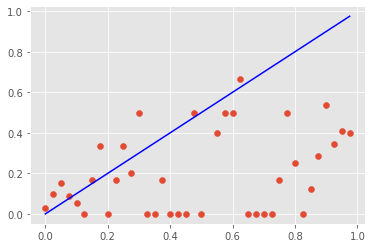

In [109]:
empirical = np.nanmean(empiricals, axis=0)
plt.plot(percentiles, percentiles, color="b")
plt.scatter(percentiles, empirical)
plt.show()

In [17]:
from bliss.catalog import TileCatalog

def compute_bayes_coverage(property, confidence_percent):
    num_coverage_attempts = 0 # not necessarily = num_trials, since we can have multiple per trial
    num_trials = 25
    num_samples = 25
    total_contained = None

    # compute empirical coverage of Bayes credible intervals: construct Bayes CI over a number of trials
    # by empirically sampling some number of times (although each "sampling" operation actually yields
    # multiple samples for the variable of interest, i.e. each sample may have multiple galaxies)
    # and computing the 90% empirical bounds for the samples. Each 90% CI and coverage event yields a *single*
    # point, since we see whether or not the truth was covered in that case

    for trial in range(num_trials):
        # generate data for a *single* run (may contain multiple "samples" of interest by the above)
        batch_size = 1
        tile_catalog = dataset.sample_prior(batch_size, cfg.datasets.simulated.n_tiles_h, cfg.datasets.simulated.n_tiles_w)
        tile_catalog.set_all_fluxes_and_mags(dataset.image_decoder)

        images, backgrounds = dataset.simulate_image_from_catalog(tile_catalog)
        full_true = tile_catalog.cpu().to_full_params()

        n_tiles_h = (images.shape[2] - 2 * enc.border_padding) // enc.detection_encoder.tile_slen
        n_tiles_w = (images.shape[3] - 2 * enc.border_padding) // enc.detection_encoder.tile_slen        

        # collect a bunch of samples for the fixed truth: note that, due to alignment, there are some
        # intricacies we have to deal with further below

        samples = []
        truths = []
        for sample in range(num_samples):
            tile_sample_dict = enc.sample(images, backgrounds, 1)
            tile_sample = TileCatalog.from_flat_dict(
                enc.detection_encoder.tile_slen,
                n_tiles_h,
                n_tiles_w,
                {k: v.squeeze(0) for k, v in tile_sample_dict.items()},
            )
            full_sample = tile_sample.cpu().to_full_params()
            
            # edge case for sampling
            if full_sample[property].shape[1] == 0 or full_true[property].shape[1] == 0:
                continue

            metrics = compute_metrics(full_true, full_sample, property, property)
            
            samples.append(metrics["pred"])
            truths.append(metrics["truth"])
        
        # very uncommon edge case for no alignment across *all* the samples
        if len(truths) == 0:
            continue

        np_truths = np.vstack([np.array(truth) for truth in truths])
        np_samples = np.vstack([np.array(sample) for sample in samples])
        
        # because of alignment, some of the sampling operations do not necessarily detect all the galaxies (or 
        # may have erroneous ones), meaning we need to extract out and align them to the corresponding truth

        unique_truths = np.unique(np_truths, axis=0)
        true_indices = []
        for truth in np_truths:
            for unique_truth_idx, unique_truth in enumerate(unique_truths):
                matched_unique = np.logical_and.reduce(np.equal(truth, unique_truth))
                if matched_unique:
                    break
            true_indices.append(unique_truth_idx)

        samples_per_truth = {}
        for idx, true_index in enumerate(true_indices):
            if true_index not in samples_per_truth:
                samples_per_truth[true_index] = []
            samples_per_truth[true_index].append(np_samples[idx])

        # after alignment, we can determine whether the corresponding truths were properly covered by the
        # empirical Bayes CI
        
        for true_index in samples_per_truth:
            samples_per_truth[true_index] = np.vstack(samples_per_truth[true_index])

            alpha = ((1 - confidence_percent) / 2) * 100
            lower_ci = np.percentile(samples_per_truth[true_index], alpha, axis=0)
            upper_ci = np.percentile(samples_per_truth[true_index], 100 - alpha, axis=0)
            contained = np.logical_and(lower_ci <= unique_truths[true_index], unique_truths[true_index] <= upper_ci).astype("int")

            if total_contained is None:
                total_contained = np.zeros_like(contained)
            total_contained += contained
            num_coverage_attempts += 1
    
    bayes_coverage = total_contained / num_coverage_attempts
    return bayes_coverage

In [18]:
galaxy_coverage = compute_bayes_coverage("galaxy_params", .90)
lens_coverage = compute_bayes_coverage("lens_params", .90)

Encoding ptiles: 1it [00:00, 30.76it/s]
Encoding ptiles: 1it [00:00, 30.91it/s]
Encoding ptiles: 1it [00:00, 35.74it/s]
Encoding ptiles: 1it [00:00, 36.27it/s]
Encoding ptiles: 1it [00:00, 36.76it/s]
Encoding ptiles: 1it [00:00, 37.23it/s]
Encoding ptiles: 1it [00:00, 37.58it/s]
Encoding ptiles: 1it [00:00, 38.20it/s]
Encoding ptiles: 1it [00:00, 39.82it/s]
Encoding ptiles: 1it [00:00, 38.43it/s]


(5,)


Encoding ptiles: 1it [00:00, 42.39it/s]
Encoding ptiles: 1it [00:00, 36.66it/s]
Encoding ptiles: 1it [00:00, 39.44it/s]
Encoding ptiles: 1it [00:00, 38.00it/s]
Encoding ptiles: 1it [00:00, 41.88it/s]
Encoding ptiles: 1it [00:00, 39.21it/s]
Encoding ptiles: 1it [00:00, 39.45it/s]
Encoding ptiles: 1it [00:00, 39.46it/s]
Encoding ptiles: 1it [00:00, 39.61it/s]
Encoding ptiles: 1it [00:00, 43.17it/s]


(5,)


Encoding ptiles: 1it [00:00, 45.40it/s]
Encoding ptiles: 1it [00:00, 47.43it/s]
Encoding ptiles: 1it [00:00, 48.11it/s]
Encoding ptiles: 1it [00:00, 47.98it/s]
Encoding ptiles: 1it [00:00, 47.86it/s]
Encoding ptiles: 1it [00:00, 47.29it/s]
Encoding ptiles: 1it [00:00, 47.61it/s]
Encoding ptiles: 1it [00:00, 34.73it/s]
Encoding ptiles: 1it [00:00, 42.22it/s]
Encoding ptiles: 1it [00:00, 42.50it/s]
Encoding ptiles: 1it [00:00, 42.54it/s]
Encoding ptiles: 1it [00:00, 42.39it/s]
Encoding ptiles: 1it [00:00, 42.47it/s]
Encoding ptiles: 1it [00:00, 45.44it/s]
Encoding ptiles: 1it [00:00, 47.86it/s]
Encoding ptiles: 1it [00:00, 47.84it/s]
Encoding ptiles: 1it [00:00, 46.95it/s]
Encoding ptiles: 1it [00:00, 47.98it/s]
Encoding ptiles: 1it [00:00, 47.92it/s]
Encoding ptiles: 1it [00:00, 48.16it/s]
Encoding ptiles: 1it [00:00, 48.39it/s]
Encoding ptiles: 1it [00:00, 46.88it/s]
Encoding ptiles: 1it [00:00, 47.23it/s]
Encoding ptiles: 1it [00:00, 47.14it/s]
Encoding ptiles: 1it [00:00, 47.17it/s]


(5,)


Encoding ptiles: 1it [00:00, 45.07it/s]
Encoding ptiles: 1it [00:00, 47.68it/s]
Encoding ptiles: 1it [00:00, 47.39it/s]
Encoding ptiles: 1it [00:00, 47.54it/s]
Encoding ptiles: 1it [00:00, 47.77it/s]
Encoding ptiles: 1it [00:00, 47.08it/s]
Encoding ptiles: 1it [00:00, 47.23it/s]
Encoding ptiles: 1it [00:00, 47.51it/s]
Encoding ptiles: 1it [00:00, 47.66it/s]
Encoding ptiles: 1it [00:00, 47.70it/s]


(5,)


Encoding ptiles: 1it [00:00, 48.24it/s]
Encoding ptiles: 1it [00:00, 48.23it/s]
Encoding ptiles: 1it [00:00, 47.63it/s]
Encoding ptiles: 1it [00:00, 48.42it/s]
Encoding ptiles: 1it [00:00, 48.41it/s]
Encoding ptiles: 1it [00:00, 48.42it/s]
Encoding ptiles: 1it [00:00, 47.86it/s]
Encoding ptiles: 1it [00:00, 47.33it/s]
Encoding ptiles: 1it [00:00, 45.16it/s]
Encoding ptiles: 1it [00:00, 47.84it/s]


(5,)


Encoding ptiles: 1it [00:00, 47.10it/s]
Encoding ptiles: 1it [00:00, 35.08it/s]
Encoding ptiles: 1it [00:00, 37.96it/s]
Encoding ptiles: 1it [00:00, 30.76it/s]
Encoding ptiles: 1it [00:00, 30.67it/s]
Encoding ptiles: 1it [00:00, 30.90it/s]
Encoding ptiles: 1it [00:00, 38.35it/s]
Encoding ptiles: 1it [00:00, 42.27it/s]
Encoding ptiles: 1it [00:00, 42.08it/s]
Encoding ptiles: 1it [00:00, 42.19it/s]


(5,)


Encoding ptiles: 1it [00:00, 40.47it/s]
Encoding ptiles: 1it [00:00, 42.22it/s]
Encoding ptiles: 1it [00:00, 42.09it/s]
Encoding ptiles: 1it [00:00, 41.80it/s]
Encoding ptiles: 1it [00:00, 42.60it/s]
Encoding ptiles: 1it [00:00, 47.51it/s]
Encoding ptiles: 1it [00:00, 47.70it/s]
Encoding ptiles: 1it [00:00, 47.23it/s]
Encoding ptiles: 1it [00:00, 47.29it/s]
Encoding ptiles: 1it [00:00, 46.85it/s]


(5,)
(5,)


Encoding ptiles: 1it [00:00, 47.53it/s]
Encoding ptiles: 1it [00:00, 46.92it/s]
Encoding ptiles: 1it [00:00, 47.38it/s]
Encoding ptiles: 1it [00:00, 46.68it/s]
Encoding ptiles: 1it [00:00, 47.22it/s]
Encoding ptiles: 1it [00:00, 47.09it/s]
Encoding ptiles: 1it [00:00, 45.66it/s]
Encoding ptiles: 1it [00:00, 47.07it/s]
Encoding ptiles: 1it [00:00, 46.25it/s]
Encoding ptiles: 1it [00:00, 47.69it/s]

(5,)


In [19]:
print(galaxy_coverage)
print(lens_coverage)

[0.57142857 0.61904762 0.61904762 0.71428571 0.71428571 0.47619048
 0.80952381]
[1.         0.88888889 1.         1.         0.88888889]


In [94]:
import numpy as np
a = np.load("../../data/sdss/psField-000094-1-0012-PSF-image.npy")

In [96]:
a.shape

(1, 25, 25)

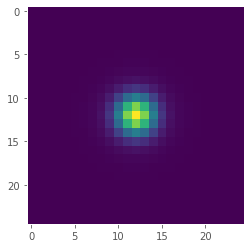

In [101]:
def sdss_psf_recon(psfield, xpos, ypos, normalize=None, trimdim=None):
    """Reconstruct the PSF at position (`xpos`, `ypos`) in an SDSS field.

    These can be read from the `psField files`_.

    .. _`psField files`: https://data.sdss.org/datamodel/files/PHOTO_REDUX/RERUN/RUN/objcs/CAMCOL/psField.html

    Parameters
    ----------
    psfield : :class:`~astropy.io.fits.fitsrec.FITS_rec`
        A PSF KL-decomposition structure read from a psField file.  This is
        from HDU's 1 through 5 in a psField file, corresponding
        to the five filters *u*, *g*, *r*, *i*, *z*.
    xpos : :class:`int`
        Column position (0-indexed, not 0.5-indexed as PHOTO outputs).
    ypos : :class:`int`
        Row position (0-indexed, not 0.5-indexed as PHOTO outputs).
    normalize : :class:`int` or :class:`float`, optional
        If set, normalize the integral of the image to this value.
    trimdim : :class:`tuple`, optional
        Trimmed dimensions; for example, set to (25, 25) to trim
        the output PSF image to those dimensions.  These dimensions
        must be odd-valued.

    Returns
    -------
    :class:`numpy.ndarray`
        The 2D reconstructed PSF image, typically dimensioned (51, 51).
        The center of the PSF is always the central pixel; this function will
        not apply any sub-pixel shifts.

    Notes
    -----
    The SDSS photo PSF is described as a set of eigen-templates, where the
    mix of these eigen-templates is a simple polynomial function with (x,y)
    position on the CCD.  Typically, there are 4 such 51x51 pixel templates.
    The polynomial functions are typically quadratic in each dimension,
    with no cross-terms.

    The formula is the following, where :math:`i` is the index of row
    polynomial order, :math:`j` is the index of column polynomial order,
    and :math:`k` is the template index:

    .. math::

        a_k &= \\sum_i \\sum_j (0.001 \\times \\mathrm{ROWC})^i \\times (0.001 \\times \\mathrm{COLC})^j \\times [C_k]_{ij} \\\\
        \\mathrm{psfimage} &= \\sum_k a_k \\mathrm{RROWS}_k

    The polynomial terms need not be of the same order for each template.

    Examples
    --------
    >>> import numpy as np
    >>> from astropy.io import fits
    >>> from astropy.utils.data import get_readable_fileobj
    >>> from pydl.photoop.image import sdss_psf_recon
    >>> psfile = ('https://data.sdss.org/sas/dr14/eboss/photo/redux/301/' +
    ...           '3366/objcs/3/psField-003366-3-0110.fit')
    >>> with get_readable_fileobj(psfile, encoding='binary') as psField:  # doctest: +REMOTE_DATA
    ...     with fits.open(psField) as hdulist:
    ...         psf = sdss_psf_recon(hdulist[3].data, 500, 500)
    """
    #
    # Hard-wired scale factor for ypos/xpos coefficients.
    #
    rc_scale = 0.001
    #
    # Assume that the dimensions of each eigen-template are the same.
    #
    rnrow = psfield['RNROW'][0]
    rncol = psfield['RNCOL'][0]
    npix = rnrow * rncol
    #
    # These are the polynomial coefficients as a function of x,y.
    # Only compute these coefficients for the maximum polynomial order in use.
    # In general, this order can be different for each eigen-template.
    #
    nr_max = psfield['nrow_b'].max()
    nc_max = psfield['ncol_b'].max()
    # nb = nrow_b * ncol_b
    coeffs = np.outer(((ypos+0.5) * rc_scale)**np.arange(nr_max), ((xpos+0.5) * rc_scale)**np.arange(nc_max))
    #
    # Reconstruct the image by summing each eigen-template.
    #
    neigen = psfield.shape[0]
    psfimage = np.zeros(psfield['RROWS'][0].shape,
                        dtype=psfield['RROWS'][0].dtype)
    for i in range(neigen):
        psfimage += (psfield['RROWS'][i] *
                     (psfield[i]['c'][0:psfield[0]['nrow_b'], 0:psfield[0]['ncol_b']] *
                      coeffs[0:psfield[0]['nrow_b'], 0:psfield[0]['ncol_b']].T).sum())
    #
    # We have reconstructed the PSF as a vector using all the
    # pixels in psfield.RROWS. So, at the end we trim this vector to only
    # those pixels used, and reform it into a 2-dimensional image.
    #
    if normalize is not None:
        psfimage /= psfimage.sum()
        psfimage *= normalize
    psfimage = psfimage[0:npix].reshape(rncol, rnrow)
    if trimdim is not None:
        psfimage = psfimage[(rncol - trimdim[0])//2:(rncol + trimdim[0])//2,
                            (rnrow - trimdim[1])//2:(rnrow + trimdim[1])//2]
    return psfimage

In [117]:
from astropy.io import fits
f = fits.open("../../data/sdss/94/1/12/psField-000094-1-0012.fits")
psf = sdss_psf_recon(f[3].data, 0, 0)
print(psf)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [115]:
np.sum(a[0,...])

1.0